In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
!pip install flat_table
import flat_table
from os.path import join
from urllib.request import urlopen
import pickle
import ast
from distutils.util import strtobool

pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', 400)

## Read data

In [ ]:
### read the already-subset data from github
url="http://raw.githubusercontent.com/ramiz11/Yelp-EDA/main/"
business = pickle.load(urlopen(join(url, 'business.pkl')))
checkin = pickle.load(urlopen(join(url, 'checkin.pkl')))
review = pickle.load(urlopen(join(url, 'review.pkl')))
tip = pickle.load(urlopen(join(url, 'tip.pkl')))
user = pickle.load(urlopen(join(url, 'user.pkl')))

## Businesses

### General Information

##### Businesses should contain all Yelp restaurants in Cleveland. Let's verify:

In [ ]:
business.city.value_counts(dropna=False)

Cleveland    1550
Name: city, dtype: int64

So we have 1550 Cleveland restaurants. What info do we have there?

In [ ]:
business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1550 entries, 41 to 209221
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   1550 non-null   object 
 1   name          1550 non-null   object 
 2   address       1550 non-null   object 
 3   city          1550 non-null   object 
 4   state         1550 non-null   object 
 5   postal_code   1550 non-null   object 
 6   latitude      1550 non-null   float64
 7   longitude     1550 non-null   float64
 8   stars         1550 non-null   float64
 9   review_count  1550 non-null   int64  
 10  is_open       1550 non-null   int64  
 11  attributes    1508 non-null   object 
 12  categories    1550 non-null   object 
 13  hours         1187 non-null   object 
dtypes: float64(3), int64(2), object(9)
memory usage: 181.6+ KB


Take a look at *the* numerical columns

In [ ]:
business.describe()

,latitude,longitude,stars,review_count,is_open
count,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000
mean,41.480909,-81.680846,3.491935,60.412258,0.693548
std,0.039813,0.081324,0.879671,111.885096,0.461168
min,41.312880,-81.866362,1.000000,3.000000,0.000000
25%,41.459236,-81.723337,3.000000,7.000000,0.000000
50%,41.488405,-81.690369,3.500000,20.000000,1.000000
75%,41.501635,-81.627517,4.000000,62.000000,1.000000
max,41.611857,-81.436705,5.000000,1372.000000,1.000000


* Half the restaurants have 20 reviews or more
* At least 50% of the restaurants are open
* The stars ratings median is 3.5, with almost identical mean

  Let's explore these further, starting with open vs. closed businesses



In [ ]:
import plotly.express as px
open = business.is_open.value_counts()
open.index = ['Open', 'Closed']
open
fig = px.pie(open, values=open, names=open.index.values, title='Try hovering over!', hole=0.35)
fig.update_traces(hoverinfo='value', textinfo='percent', textfont_size=20)
fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
fig.show()

In [400]:
bizrev = business.loc[business.is_open == 1, 'review_count']
pd.cut(bizrev, 5).value_counts()

groups = bizrev.groupby(['review_count', pd.cut(bizrev.review_count, bins)])
groups.size().unstack()

(1.631, 276.8]      1017
(276.8, 550.6]        41
(550.6, 824.4]        11
(824.4, 1098.2]        4
(1098.2, 1372.0]       2
Name: review_count, dtype: int64

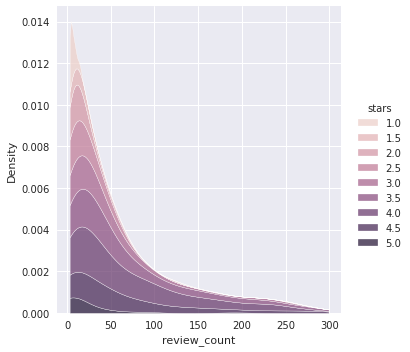

In [403]:
sns.displot(business.loc[(business.is_open == 1) & (business.review_count <= 300)],
            x="review_count", hue="stars", kind="kde", multiple="stack", cut=0)

In [ ]:
logmin, logmax = np.log10(biz_rev.min()), np.log10(biz_rev.max())
log_bins = np.logspace(logmin, logmax, 10)
sns.displot(biz_rev, bins=log_bins, kde=False)

## Check-Ins

In [ ]:
checkin.head()

,business_id,date
136,-23R9P2eG7VTc6DVLjFKzA,"2011-12-21 19:02:51, 2012-04-15 04:21:39, 2012-04-15 14:23:56, 2013-06-30 22:39:51, 2013-10-04 20:34:13, 2014-07-16 02:28:40"
624,-DU8jf5nA1_yaOqsKsLqmw,"2012-05-19 00:26:19, 2013-04-25 21:31:35, 2013-07-12 21:21:37, 2013-09-15 19:52:09, 2014-06-22 02:23:01, 2014-12-18 22:14:15, 2014-12-28 05:18:22, 2017-04-25 23:35:51"
636,-DkhPijabXuTNvNteIpRPw,"2010-10-22 23:00:05, 2010-10-25 00:37:55, 2010-10-28 01:46:15, 2010-11-02 02:52:50, 2010-11-07 23:12:20, 2010-12-30 05:21:19, 2010-12-30 05:21:50, 2010-12-31 22:00:30, 2011-10-14 04:44:42, 2011-11-30 05:05:27, 2011-12-30 04:32:31, 2012-01-05 02:50:22, 2012-01-15 05:57:09, 2012-02-01 04:15:10, 2012-02-19 06:23:50, 2012-02-22 09:28:36, 2012-03-07 07:39:57, 2012-03-09 04:18:57, 2012-04-01 02:22:4..."
693,-F0B5F1YLx7093otwgboxw,"2016-03-31 23:14:40, 2016-04-01 04:02:28, 2016-04-01 21:46:10, 2016-04-03 01:46:46, 2016-04-04 20:48:02, 2016-04-04 22:32:37, 2016-04-06 23:56:49, 2016-04-08 21:56:40, 2016-04-11 16:55:09, 2016-04-16 00:45:52, 2016-04-17 17:36:41, 2016-04-17 17:37:14, 2016-05-05 21:02:28, 2016-05-06 22:54:12, 2016-05-09 01:00:08, 2016-05-10 22:11:48, 2016-05-10 23:25:04, 2016-05-13 21:14:05, 2016-05-17 22:56:3..."
756,-GQzMguGfB4jswo8jAO7CQ,"2011-11-06 05:10:54, 2012-08-02 00:40:54, 2012-09-16 12:54:33, 2013-10-20 11:37:08, 2013-10-23 09:04:24, 2013-11-13 11:55:26, 2013-11-19 10:51:00, 2014-01-17 21:01:31, 2014-04-14 09:59:07, 2014-04-30 09:54:42, 2014-12-30 12:50:33, 2014-12-31 11:43:40, 2015-01-02 12:10:30, 2017-02-28 21:39:02, 2017-04-18 23:00:52, 2017-12-09 16:23:49"


##### Normalize dates
Have each date in a separated row

In [ ]:
checkin = checkin.assign(date=checkin.date.str.split(',')).explode('date')
checkin['date'] = pd.to_datetime(checkin.date)
checkin.head()

,business_id,date
136,-23R9P2eG7VTc6DVLjFKzA,2011-12-21 19:02:51
136,-23R9P2eG7VTc6DVLjFKzA,2012-04-15 04:21:39
136,-23R9P2eG7VTc6DVLjFKzA,2012-04-15 14:23:56
136,-23R9P2eG7VTc6DVLjFKzA,2013-06-30 22:39:51
136,-23R9P2eG7VTc6DVLjFKzA,2013-10-04 20:34:13


##### What are the checkin date ranges?

In [ ]:
print(f"Checking dates range from {checkin.date.min().strftime('%B %d, %Y')} to {checkin.date.max().strftime('%B %d, %Y')}")

Checking dates range from January 16, 2010 to December 13, 2019


##### We saw that 1,075 restaurants are open - let's compare it to the number of checkins over time
Use 2018 - 2019 checkins excluding Dec-2019 being a partial month



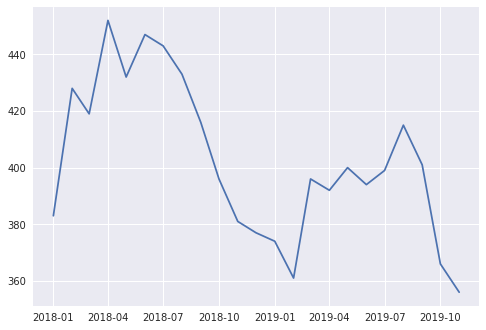

In [ ]:
checks = checkin[(checkin.date >= '2018-01-01') & (checkin.date <= '2019-11-30')]
checks = checks.groupby(checks.date.dt.strftime('%Y-%m'))['business_id'].nunique()
checks.index = pd.to_datetime(checks.index,format='%Y-%m')
plt.plot(checks)

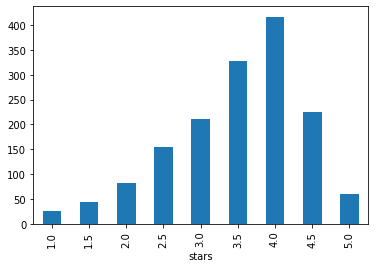

In [ ]:
business.groupby('stars').size().plot.bar()

### Create categories


In [ ]:
business.categories

41                                                                                                                                    Restaurants, Vietnamese, Soup
49                                                                                                                                  Restaurants, Fast Food, Burgers
54        Shopping Centers, Food, Coffee & Tea, Cafes, Museums, Restaurants, Shopping, Local Flavor, Flowers & Gifts, Arts & Entertainment, Art Galleries, Florists
173                                                                                                                     Diners, American (Traditional), Restaurants
623                                                                                                             Italian, Pizza, Restaurants, American (Traditional)
                                                                                    ...                                                                            
208990          

##### Arrange categories in columns

In [ ]:
business.categories.str.split(',', expand=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
41,Restaurants,Vietnamese,Soup,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
49,Restaurants,Fast Food,Burgers,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
54,Shopping Centers,Food,Coffee & Tea,Cafes,Museums,Restaurants,Shopping,Local Flavor,Flowers & Gifts,Arts & Entertainment,Art Galleries,Florists,None,None,None,None,None,None,None
173,Diners,American (Traditional),Restaurants,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
623,Italian,Pizza,Restaurants,American (Traditional),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208990,American (Traditional),Restaurants,Fast Food,Chicken Wings,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
209055,Middle Eastern,Restaurants,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
209150,Sandwiches,Breakfast & Brunch,Restaurants,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
209203,Chinese,Restaurants,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


##### Since the category values are mixed with no particular hierarchy...
let's collect all category values to decide which ones seem useful

In [ ]:
categories = ' '.join(business.categories).split(',')
categories = pd.DataFrame(list(set([category.replace("\'|&", '').strip() for category in categories])))
categories

,0
0,Japanese
1,Fast Food Bars
2,Pasta Shops Salad
3,Greek Bars
4,Restaurants Adult Entertainment
...,...
1027,Caribbean Sandwiches
1028,Restaurants Irish
1029,Hungarian Greek
1030,American (Traditional) American (New)


##### Check which are the most frequent onces, and use them to build some new features

In [ ]:
business.categories.str.split(',\s+', expand=True).stack().value_counts()

Restaurants               1550
Food                       405
Nightlife                  330
Bars                       318
American (Traditional)     260
                          ... 
Fitness & Instruction        1
Boat Charters                1
Knife Sharpening             1
Day Spas                     1
Home Services                1
Length: 261, dtype: int64

##### build 3 new features = sub-categories: the restaurant region, the business type, and veggy/vegan food

In [ ]:
values = ['American (Traditional)', 'American (New)', 'Italian', 'Chinese', 'Mexican', 'Mediterranean', 'Japanese', 'Asian Fusion', 'Thai', 'Indian', 'Middle Eastern', 'Greek', 'Latin American', 'French', 'Turkish', 'Korean', 'Caribbean', 'Southern', 'Vietnamese', 'Taiwanese', 'Pakistani', 'Szechuan']
conditions = list(map(business.categories.str.contains, values))
business['region'] = np.select(conditions, values, 'other')
business.region.value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


other             1052
Italian            107
Chinese            103
Mexican             75
Mediterranean       39
Japanese            31
Latin American      23
Middle Eastern      20
Indian              16
Asian Fusion        16
Southern            14
Thai                12
French              11
Greek                9
Caribbean            8
Vietnamese           8
Korean               5
Turkish              1
Name: region, dtype: int64

In [ ]:
values = ['Bars', 'Fast Food', 'Burgers', 'Cafes', 'Event Planning & Services', 'Delis', 'Caterers', 'Diners', 'Cocktail Bars', 'Bakeries', 'Sushi Bars', 'Sports Bars', 'Pubs', 'Steakhouses', 'Food Trucks', 'Lounges', 'Wine Bars', 'Arts & Entertainment', 'Beer Bar', 'Food Delivery Services', 'Grocery', 'Dive Bars', 'Gastropubs', 'Venues & Event Spaces']
conditions = list(map(business.categories.str.contains, values))
business['business_type'] = np.select(conditions, values, 'other')
business.business_type.value_counts()

other                        697
Bars                         370
Fast Food                    163
Delis                         61
Cafes                         49
Bakeries                      47
Burgers                       44
Event Planning & Services     42
Diners                        34
Arts & Entertainment          12
Steakhouses                   11
Food Trucks                    8
Grocery                        5
Food Delivery Services         4
Gastropubs                     3
Name: business_type, dtype: int64

In [ ]:
conditions = list(map(business.categories.str.lower().str.contains, ['veg']))
business['veggy'] = np.select(conditions, ['veg'], 'other')
business.veggy.value_counts()

other    1515
veg        35
Name: veggy, dtype: int64

### Flatten complex objects

##### Attributes: handle missing values, clean special unicode u' symbols



In [ ]:
business['attributes'] = business.attributes.apply(lambda x: {} if x is None else x)
business['attributes'] = business.attributes.apply(lambda x: ast.literal_eval(json.dumps(x).replace("u\'", "")))

##### Start with *attributes* and business hours

In [ ]:
business_data = business.drop(['attributes', 'hours'], axis=1)
flat_cols = flat_table.normalize(business[['attributes', 'hours']])
business = pd.concat([business_data.reset_index(drop=True), flat_cols], axis=1)
business.columns = [x[len('attributes.'):] if x.startswith('attributes.') else x for x in business.columns]
business.columns = [x[len('hours.'):] if x.startswith('hours.') else x for x in business.columns]

In [ ]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 59 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 1550 non-null   object 
 1   name                        1550 non-null   object 
 2   address                     1550 non-null   object 
 3   city                        1550 non-null   object 
 4   state                       1550 non-null   object 
 5   postal_code                 1550 non-null   object 
 6   latitude                    1550 non-null   float64
 7   longitude                   1550 non-null   float64
 8   stars                       1550 non-null   float64
 9   review_count                1550 non-null   int64  
 10  is_open                     1550 non-null   int64  
 11  categories                  1550 non-null   object 
 12  region                      1550 non-null   object 
 13  business_type               1550 

##### Flatten additional attributes

In [ ]:
def flatten_col(df, col):
    df[col] = df[col].apply(lambda x: '{}' if len(str(x))<=5 else x)
    df[col] = df[col].replace("\'", "\"")
    df[col] = df[col].apply(ast.literal_eval)
    df = pd.concat([df.drop([col], axis=1).reset_index(drop=True), pd.json_normalize(df[col])], axis=1)
    return df


In [ ]:
business = flatten_col(business, 'GoodForMeal')
business = flatten_col(business, 'Ambience')
business = flatten_col(business, 'BusinessParking')
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 76 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 1550 non-null   object 
 1   name                        1550 non-null   object 
 2   address                     1550 non-null   object 
 3   city                        1550 non-null   object 
 4   state                       1550 non-null   object 
 5   postal_code                 1550 non-null   object 
 6   latitude                    1550 non-null   float64
 7   longitude                   1550 non-null   float64
 8   stars                       1550 non-null   float64
 9   review_count                1550 non-null   int64  
 10  is_open                     1550 non-null   int64  
 11  categories                  1550 non-null   object 
 12  region                      1550 non-null   object 
 13  business_type               1550 

### Cleanup & modify column types

##### Drop columns containing mostly null values 

In [ ]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 76 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 1550 non-null   object 
 1   name                        1550 non-null   object 
 2   address                     1550 non-null   object 
 3   city                        1550 non-null   object 
 4   state                       1550 non-null   object 
 5   postal_code                 1550 non-null   object 
 6   latitude                    1550 non-null   float64
 7   longitude                   1550 non-null   float64
 8   stars                       1550 non-null   float64
 9   review_count                1550 non-null   int64  
 10  is_open                     1550 non-null   int64  
 11  categories                  1550 non-null   object 
 12  region                      1550 non-null   object 
 13  business_type               1550 

In [ ]:
drop_cols = ['AcceptsInsurance', 'AgesAllowed', 'DietaryRestrictions', 'BYOBCorkage', 'Corkage', 'BYOB']
business.drop(drop_cols, axis=1, inplace=True)

##### Check the new attributes which were added during flattening
Check string and float columns which might need a conversion to boolean

In [ ]:
print('string:')
for col in business.columns:
    if isinstance(business[col][0], str):
        print(col)
print()
print('float:')
for col in business.columns:
    if isinstance(business[col][0], float):
        print(col)

string:
business_id
name
address
city
state
postal_code
categories
region
business_type
veggy
RestaurantsDelivery
Caters
RestaurantsTakeOut
WheelchairAccessible
RestaurantsTableService
WiFi
OutdoorSeating
HasTV
Alcohol
BikeParking
BusinessAcceptsCreditCards
Sunday
Saturday
Friday
Thursday
Wednesday
Monday

float:
latitude
longitude
stars
ByAppointmentOnly
BusinessAcceptsBitcoin
DogsAllowed
DriveThru
BestNights
Smoking
Music
GoodForDancing
CoatCheck
HappyHour
RestaurantsGoodForGroups
RestaurantsReservations
RestaurantsPriceRange2
RestaurantsAttire
NoiseLevel
GoodForKids
Tuesday
garage
street
validated
lot
valet


In [ ]:
str_bool = ['RestaurantsDelivery', 'Caters', 'RestaurantsTakeOut', 'WheelchairAccessible',
            'RestaurantsTableService', 'OutdoorSeating', 'HasTV', 'BikeParking', 'BusinessAcceptsCreditCards']
for col in str_bool:
    business[col] = business[col].apply(lambda x: bool(strtobool(str(x))) if x in ['True', 'False'] else None)
# also keep track of the additional columns which are boolean by nature
float_bool = ['ByAppointmentOnly', 'BusinessAcceptsBitcoin', 'DogsAllowed', 'DriveThru', 'GoodForDancing', 'CoatCheck',
            'HappyHour', 'RestaurantsGoodForGroups', 'RestaurantsReservations', 'GoodForKids',
            'garage', 'street', 'validated', 'lot', 'valet']


#### drop the "not-so-interesting" boolean columns having less than 100 True values

In [ ]:
val_count = business[str_bool].apply(pd.Series.value_counts).T[True]
drop_cols = val_count.index[val_count<100].to_list()
val_count = business[float_bool].apply(pd.Series.value_counts).T['True']
drop_cols = drop_cols + val_count.index[val_count<100].to_list()
drop_cols

['ByAppointmentOnly',
 'BusinessAcceptsBitcoin',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'CoatCheck']

In [ ]:
# drop these columns
business.drop(drop_cols, axis=1, inplace=True)
business.drop('index', axis=1, inplace=True)

##### Clean redundant quotes
for example, let's look at WiFi

In [ ]:
business.WiFi.value_counts()

free'     381
no'       317
'no'      157
'free'    133
paid'       7
'paid'      3
None        1
Name: WiFi, dtype: int64

In [ ]:
for col in ['WiFi', 'Alcohol', 'Smoking', 'RestaurantsAttire', 'NoiseLevel']:
    business[col] = business[col].str.replace("\'", "")

business.WiFi.value_counts()

free    514
no      474
paid     10
None      1
Name: WiFi, dtype: int64

## Explore business activity

#### Open businesses during week days

In [ ]:
weekdays=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
business.loc[business.is_open == 1, weekdays].head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,11:0-20:0,NaN,11:0-20:0,11:0-20:0,11:0-20:0,11:0-20:0,11:0-20:0
1,10:0-3:0,10:0-3:0,10:0-3:0,10:0-3:0,10:0-3:0,10:0-3:0,10:0-3:0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,7:0-15:0,7:0-15:0,7:0-15:0,7:0-15:0,7:0-15:0,NaN,NaN


* Cleanse the opening-hours columns
* Filter out closed businesses
* Check on which days businesses are open

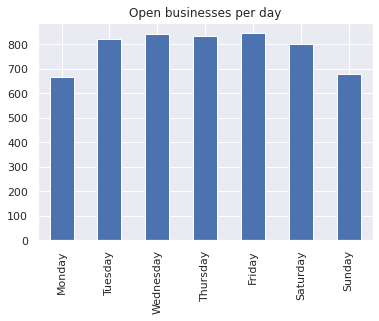

In [ ]:
business[weekdays] = business[weekdays].replace({'0:0-0:0':np.nan})
opendays = business.loc[business.is_open == 1, weekdays].notnull()
plt.title('Open businesses per day')
opendays.T.sum(axis=1).plot(kind="bar")

* Looks like Monday is the slowest day (off-time is Sun-Mon, not Sat-Sun) 
* Check out percentages, too: only ~ 62% of the open restaurants work on Mondays

In [ ]:
open_closed = opendays.replace([True, False], ['Open', 'Closed']) 
open_closed.apply(lambda x: x.value_counts(normalize=True))

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Open,0.619535,0.763721,0.784186,0.776744,0.786977,0.746977,0.633488
Closed,0.380465,0.236279,0.215814,0.223256,0.213023,0.253023,0.366512


### Explore the categories

## Users

In [ ]:
elite_years = user.elite.str.split(',', expand=True)
elite_years.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
116,2011,None,None,None,None,None,None,None,None,None,None,None,None
407,2012,2013,2014,2015,2016,2017,2018,None,None,None,None,None,None
732,2010,2011,2012,2013,2014,2015,2016,2017,2018,None,None,None,None
830,2014,2015,2016,2017,2018,None,None,None,None,None,None,None,None
851,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,None


In [ ]:
elite_count = user.elite.str.split(',\d+', expand=True).stack().value_counts()
elite_count

        15502
2018      515
2017      305
2016      193
2015      155
2014       82
2012       57
2011       44
2013       42
2010       31
2009       14
2007        7
2008        4
2006        2
dtype: int64

In [ ]:
user['elite_2018'] = np.where(user.elite.str.contains('2018'), True, False)
user.elite_2018.value_counts()

False    13324
True      1276
Name: elite_2018, dtype: int64

## Reviews

In [ ]:
pd.to_datetime(review.date).dt.to_period('Y').value_counts()

2018    14408
2019    12720
Freq: A-DEC, Name: date, dtype: int64

In [ ]:
max(pd.to_datetime(review.date))

Timestamp('2019-12-13 15:35:41')

In [ ]:
len(review)

27128

In [ ]:
len(review[pd.to_datetime(review.date).dt.to_period('Y').astype(str).astype(int) >= 2018])

27128

## Questions & Ideas
* Intro
    * businesses, checkins, reviews, users intro (head, info, missing)
    * look at categorical cols - describe, ranges
    * look at numerical cols - value_counts, ranges
* How many restaurants and users? (histogram)
    * Does it change over time? (plot)
* how are the restaurants categories distributed?
    * Who are the top restaurants in each category?
* How many reviews do businesses have? how many by one user?
* investigate specific businesses (per category and best/worse)
    * attributes, ratings, reviews, and checkins over time, top words
* Categories and attributes deeper look
    * Which categories and attributes have higher rating, checkins, # reviews ? (plot, group/bins, corr crosstab, heat map, cluster map)
    * Which categories and businesses are trending +/- or new? (checkins, stars, # reviews, open/close)
* Openning/closing restaurants
    * How many businesses are open and closed? what is the trend?
    * Validate there are no reviews and checkins for closed restaurants
    * Do restaurants before closure have less stars? checkins and reviews?
* Which restaurant is the best for me?
* How many elite, active, inactive users are there?
    * Do elite status users, with many friends and compliments, rate differently?
    * Do friends have similar categories preferences and rating?
    * Do successful restaurants have more or less useful reviews?

In [ ]:
%cd '/content/mnt/My Drive/uploads'

/content/mnt/My Drive/uploads
